In [1]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
import os,random
#os.environ["KERAS_BACKEND"] = "theano"
os.environ["KERAS_BACKEND"] = "tensorflow"
#os.environ["THEANO_FLAGS"]  = "device=gpu%d"%(1)
import numpy as np
import theano as th
import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Permute,Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, Conv1D, MaxPooling2D, ZeroPadding2D, ZeroPadding1D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import *
from keras.optimizers import adam, SGD

import matplotlib.pyplot as plt
#import seaborn as sns
import cPickle, random, sys, keras

import config

Using TensorFlow backend.


In [2]:
import detregionloss
reload(detregionloss)

dr = 0.5
conv_size = (3,3)
model = models.Sequential()
model.add(Conv2D(16, conv_size, padding="same", strides=(1, 1), input_shape=(128, 128,2), name='conv1'))
#model.add(BatchNormalization(name='batchnorm1')) # We don't add any axis as last is correct 
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, conv_size, padding="same", name='conv2'))
#model.add(BatchNormalization(name='batchnorm2'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))

model.add(Conv2D(64, conv_size, padding="same", name='conv3'))
#model.add(BatchNormalization(name='batchnorm3'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))

model.add(Conv2D(128, conv_size, padding="same", name='conv4'))
#model.add(BatchNormalization(name='batchnorm4'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))

model.add(Conv2D(256, conv_size, padding="same", name='conv5'))
#model.add(BatchNormalization(name='batchnorm5'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))

model.add(Conv2D(512, conv_size, padding="same", name='conv6'))
#model.add(BatchNormalization(name='batchnorm6'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))

model.add(Conv2D(1024, conv_size, padding="same", name='conv7'))
#model.add(BatchNormalization(name='batchnorm7'))
model.add(LeakyReLU(alpha=0.1))

# Before this line is the Darknet Reference Model. After is the YOLO additions
# This is the OLD tiny-yolo model, circa mid-2016. We'll start with this and perhaps go to the
# new one later on. 

model.add(Conv2D(1024, conv_size, padding="same"))
#model.add(BatchNormalization(name='batchnorm8'))
model.add(LeakyReLU(alpha=0.1))

model.add(Conv2D(256, conv_size, padding="same"))
#model.add(BatchNormalization(name='batchnorm9'))
model.add(LeakyReLU(alpha=0.1))

model.add(Flatten())
model.add(Dense(4096))
#model.add(BatchNormalization(name='batchnorm10'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(dr, noise_shape=None, seed=None))
model.add(Dense(config.S_GRID**2*(5*config.B_BOXES+config.C_CLASS)))

sgd = SGD(lr=0.001, decay=0, momentum=0.9)
model.compile(loss=detregionloss.regionloss, optimizer=sgd, metrics = [])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 128, 128, 16)      304       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 64, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 32, 32, 64)        18496     
__________

In [3]:
filepath = 'spectrumCNN_Localized.wts.h5'
model.load_weights(filepath)

In [4]:
def sense_object_file(model, fft_img, th):
    
    BW = 30
    SEC = 10
    
    def construct(width, height, centerx, centery, label):
        res = {}
        res['bandwidth'] = int(width * BW)
        res['center_freqency'] = int(centerx * BW + 900)
        res['start_time'] = float((centery - height / 2) * SEC)
        res['duration'] = float(height * SEC)
        res['modulation'] = label
        
        return res

    norm_data = train_set.normalize_data(fft_img)
    
    model_out = model.predict(np.array([norm_data]), batch_size=1)

    boxes =  utils.yolo_net_out_to_boxes(model_out, threshold=th)
    
    channels = []
    
    for box in boxes:
        channels.append(construct(box.w, box.h, box.x, box.y, config.CLASS_TYPES[box.label_index]))
    
    return (channels, boxes)

In [5]:
from dataset.dataset_model import dataset_model
path = "../data/test_set_object/"
train_set = dataset_model('../data/multi_channel_objects', localization_dataset = True)

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac28cc290>, <utils.utils.Box instance at 0x7f2ac28cc4d0>, <utils.utils.Box instance at 0x7f2ac28cc758>, <utils.utils.Box instance at 0x7f2ac28cc7a0>]
[<utils.utils.Box instance at 0x7f2ac28cc290>, <utils.utils.Box instance at 0x7f2ac28cc4d0>, <utils.utils.Box instance at 0x7f2ac28cc758>, <utils.utils.Box instance at 0x7f2ac28cc7a0>]


/usr/local/lib/python2.7/dist-packages/matplotlib/patches.py:120: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


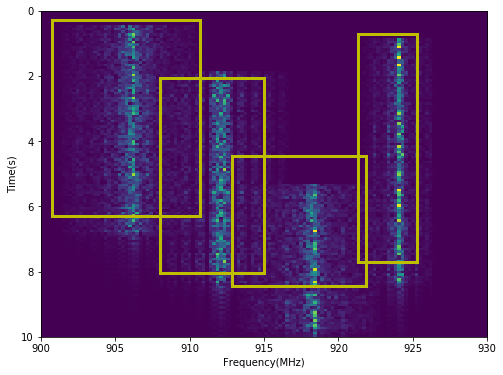

------------------
True:
{'width': 42, 'height': 83, 'center': (25, 41), 'label': 'PSK8'}
{'width': 42, 'height': 83, 'center': (51, 60), 'label': 'PSK2'}
{'width': 42, 'height': 57, 'center': (76, 92), 'label': 'QAM64'}
{'width': 21, 'height': 96, 'center': (102, 54), 'label': 'QAM4'}
------------------
Predict:
{'duration': 6.213182806968689, 'modulation': 'PSK16', 'bandwidth': 10, 'start_time': 0.29992912496839275, 'center_freqency': 905}
{'duration': 6.21148407459259, 'modulation': 'PSK2', 'bandwidth': 7, 'start_time': 2.0508621845926553, 'center_freqency': 911}
{'duration': 4.073909223079681, 'modulation': 'QAM64', 'bandwidth': 9, 'start_time': 4.457447677850723, 'center_freqency': 917}
{'duration': 7.50029444694519, 'modulation': 'QAM4', 'bandwidth': 4, 'start_time': 0.7131333010537283, 'center_freqency': 923}


In [6]:
filename = 'object781.dat'
threshold = 0.52

from utils import utils
import matplotlib.patches as patches

def draw_img(fft_img, boxes):
    W = 30
    H = 10
    X_OFFSET = 900
    def get_para(box):
        return (((box.x - box.w / 2) * W + X_OFFSET, (box.y - box.h / 2) * H), 
                 int(box.w * W), 
                 int(box.h * H))
    
    mag_data = np.sqrt(np.power(fft_img[:,:,0],2) + np.power(fft_img[:,:,1],2))
    # Create figure and axes
    fig,ax = plt.subplots(1, figsize=(8,6))
    # Display the image
    ax.imshow((mag_data), extent=(900, 930, 10, 0), aspect='auto')
    plt.xlabel('Frequency(MHz)')
    plt.ylabel('Time(s)')
    for box in boxes:
        # Create a Rectangle patch
        rect = patches.Rectangle(*get_para(box),linewidth=1,edgecolor='r',facecolor='none', 
                                 lw=3, color='y', fill=False)

        # Add the patch to the Axes
        ax.add_patch(rect)
    plt.show()

datapoint = cPickle.load(open(os.path.join(path,filename)))
channels, boxes = sense_object_file(model, datapoint['data'], threshold)
draw_img(datapoint['data'], boxes)
print('------------------')
print('True:')
for object in datapoint['objects']:
    print(object)
print('------------------')
print('Predict:')
for channel in channels:
    print(channel)

In [9]:
class Box:
    pass
def calculate_accuracy(path, num_files, threshold):        
    W, H = 128.0, 128.0
    
    def convert_to_box(signal):
        box = Box()
        box.x, box.y = signal['center'][0] / W, signal['center'][1]/H
        box.w = signal['width'] / W
        box.h = signal['height'] / H
        
        return box
        
    def get_nearest_box(true_box, boxes):
        def get_dist(box1, box2):
            return ((box1.x - box2.x)**2 + (box1.y - box2.y)**2)**(.5)
        
        if not boxes:
            return None
        
        nearest_box = None
        nearest_dist = 10.0
        for box in boxes:
            if get_dist(true_box, box) < nearest_dist:
                nearest_dist = get_dist(true_box, box)
                nearest_box = box
        
        return nearest_box
    
    def get_overlap(box1, box2):
        def convert(box):
            t = box.y - box.h / 2
            l = box.x - box.w / 2
            b = box.y + box.h / 2
            r = box.x + box.w / 2
            
            return (t,l,b,r)
        
        if not box2:
            return 0.0
        (t1,l1,b1,r1) = convert(box1)
        (t2,l2,b2,r2) = convert(box2)
        
        t = max(t1, t2)
        l = max(l1, l2)
        b = min(b1, b2)
        r = min(r1, r2)
        
        box = Box()
        box.x = (l + r) / 2
        box.y = (t + b) / 2
        box.w = max(r - l, 0)
        box.h = max(b - t, 0)
        
        return box
    
    def get_area(box):
        return box.w * box.h
        
    accuracy_total = 0.0
    for i in range(num_files):
        overlap_acc = 0.0
        total_acc = 0.0
        file_name = 'object' + str(i) + '.dat'
        datapoint = cPickle.load(open(os.path.join(path,filename)))
        channels, boxes = sense_object_file(model, datapoint['data'], threshold)
#         for box in boxes:
#             print('x: {}, y: {}, w: {}, h: {}'.format(box.x, box.y, box.w, box.h))
        for signal in datapoint['objects']:
            true_box = convert_to_box(signal)
            nearest_box = get_nearest_box(true_box, boxes)
            overlap_box = get_overlap(true_box, nearest_box)
            overlap_acc += 2 * get_area(overlap_box)# + get_area(overlap_box) 
            total_acc += get_area(true_box) + get_area(nearest_box) #- get_area(overlap_box)
            
#             print('{}'.format(total_acc))
#             print(signal)
#             print('x: {}, y: {}, w: {}, h: {}'.format(true_box.x, true_box.y, true_box.w, true_box.h))
#             print('x: {}, y: {}, w: {}, h: {}'.format(nearest_box.x, nearest_box.y, nearest_box.w, nearest_box.h))
#             print('x: {}, y: {}, w: {}, h: {}'.format(overlap_box.x, overlap_box.y, overlap_box.w, overlap_box.h))
#             print('---------------')
        accuracy_total += overlap_acc / total_acc
    
    return accuracy_total / num_files

In [10]:
path = "../data/test_set_object/"
threshold = 0.52
num_files = 986
print(calculate_accuracy(path, num_files, threshold))

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac27f6758>, <utils.utils.Box instance at 0x7f2a593ee098>, <utils.utils.Box instance at 0x7f2a58db4680>, <utils.utils.Box instance at 0x7f2ac279ab48>]
[<utils.utils.Box instance at 0x7f2ac27f6758>, <utils.utils.Box instance at 0x7f2a593ee098>, <utils.utils.Box instance at 0x7f2a58db4680>, <utils.utils.Box instance at 0x7f2ac279ab48>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac289ab00>, <utils.utils.Box instance at 0x7f2ac289acf8>, <utils.utils.Box instance at 0x7f2ac2791dd0>, <utils.utils.Box instance at 0x7f2ac27915f0>]
[<utils.utils.Box instance at 0x7f2ac289ab00>, <utils.utils.Box instance at 0x7f2ac289acf8>, <utils.utils.Box instance at 0x7f2ac2791dd0>, <utils.utils.Box instance at 0x7f2ac27915f0>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac27f6680>, <utils.utils.Box instance at 0x7f2a58db4680>, <utils.utils.Box instance at 0x7f2ac289a560>, <utils.utils.Box instance at 0x7f2ac2791a70>]
[<utils.utils.Box instance at 0x7f2ac27f6680>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac2791a70>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d7a0>]
[<utils.utils.Box instance at 0x7f2ac2791a70>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d7a0>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d368>, <utils.utils.Box instance at 0x7f2a58d7d7e8>]
[<utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d368>, <utils.utils.Box instance at 0x7f2a58d7d7e8>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac27915f0>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d908>]
[<utils.utils.Box instance at 0x7f2ac27915f0>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac289acf8>, <utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d908>]
[<utils.utils.Box instance at 0x7f2ac289acf8>, <utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d908>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d758>, <utils.utils.Box instance at 0x7f2a58d7d5f0>]
[<utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d758>, <utils.utils.Box instance at 0x7f2a58d7d5f0>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d368>, <utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d518>]
[<utils.utils.Box instance at 0x7f2a58d7d368>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d7a0>]
[<utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d7a0>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d908>, <utils.utils.Box instance at 0x7f2a58d7d488>]
[<utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d908>, <utils.utils.Box instance at 0x7f2a58d7d488>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58db4680>, <utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d518>]
[<utils.utils.Box instance at 0x7f2a58db4680>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d368>, <utils.utils.Box instance at 0x7f2a58d7d878>]
[<utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d368>, <utils.utils.Box instance at 0x7f2a58d7d878>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d758>]
[<utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d758>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac289a560>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d368>, <utils.utils.Box instance at 0x7f2a58d7d440>]
[<utils.utils.Box instance at 0x7f2ac289a560>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac2791a70>, <utils.utils.Box instance at 0x7f2a58d7d758>, <utils.utils.Box instance at 0x7f2a58d7d908>, <utils.utils.Box instance at 0x7f2a58d7d488>]
[<utils.utils.Box instance at 0x7f2ac2791a70>, <utils.utils.Box instance at 0x7f2a58d7d758>, <utils.utils.Box instance at 0x7f2a58d7d908>, <utils.utils.Box instance at 0x7f2a58d7d488>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d8c0>]
[<utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d8c0>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a593ee098>, <utils.utils.Box instance at 0x7f2a58d7d758>, <utils.utils.Box instance at 0x7f2a58d7d908>, <utils.utils.Box instance at 0x7f2a58d7d878>]
[<utils.utils.Box instance at 0x7f2a593ee098>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac28cc368>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d5a8>]
[<utils.utils.Box instance at 0x7f2ac28cc368>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d5a8>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d908>, <utils.utils.Box instance at 0x7f2a58d7d830>]
[<utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d908>, <utils.utils.Box instance at 0x7f2a58d7d830>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d518>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d488>]
[<utils.utils.Box instance at 0x7f2a58d7d518>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d5f0>, <utils.utils.Box instance at 0x7f2a58d7d7e8>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d5a8>]
[<utils.utils.Box instance at 0x7f2a58d7d5f0>, <utils.utils.Box instance at 0x7f2a58d7d7e8>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d5a8>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d758>, <utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d878>]
[<utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d758>, <utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d878>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58db4680>, <utils.utils.Box instance at 0x7f2a58d7d7e8>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d830>]
[<utils.utils.Box instance at 0x7f2a58db4680>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a5938a5a8>, <utils.utils.Box instance at 0x7f2a58d7d908>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d5a8>]
[<utils.utils.Box instance at 0x7f2a5938a5a8>, <utils.utils.Box instance at 0x7f2a58d7d908>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d5a8>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d368>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d638>]
[<utils.utils.Box instance at 0x7f2a58d7d368>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d638>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac27f6680>, <utils.utils.Box instance at 0x7f2a58d7d908>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d5f0>]
[<utils.utils.Box instance at 0x7f2ac27f6680>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d7e8>, <utils.utils.Box instance at 0x7f2a58d7d368>, <utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d8c0>]
[<utils.utils.Box instance at 0x7f2a58d7d7e8>, <utils.utils.Box instance at 0x7f2a58d7d368>, <utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d8c0>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d758>]
[<utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d758>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac27910e0>, <utils.utils.Box instance at 0x7f2a58d7d368>, <utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d878>]
[<utils.utils.Box instance at 0x7f2ac27910e0>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac2791170>, <utils.utils.Box instance at 0x7f2ac279abd8>, <utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d440>]
[<utils.utils.Box instance at 0x7f2ac2791170>, <utils.utils.Box instance at 0x7f2ac279abd8>, <utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d440>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d758>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d7e8>, <utils.utils.Box instance at 0x7f2a58d7d7a0>]
[<utils.utils.Box instance at 0x7f2a58d7d758>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d7e8>, <utils.utils.Box instance at 0x7f2a58d7d7a0>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac27f6680>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d830>]
[<utils.utils.Box instance at 0x7f2ac27f6680>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a5938a5a8>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d758>]
[<utils.utils.Box instance at 0x7f2a5938a5a8>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d758>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d7e8>, <utils.utils.Box instance at 0x7f2a58d7d6c8>]
[<utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d7e8>, <utils.utils.Box instance at 0x7f2a58d7d6c8>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac2791098>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d7a0>]
[<utils.utils.Box instance at 0x7f2ac2791098>

[<utils.utils.Box instance at 0x7f2ac279abd8>, <utils.utils.Box instance at 0x7f2a58d7d908>, <utils.utils.Box instance at 0x7f2a58d7d518>, <utils.utils.Box instance at 0x7f2a58d7d440>]
[<utils.utils.Box instance at 0x7f2ac279abd8>, <utils.utils.Box instance at 0x7f2a58d7d908>, <utils.utils.Box instance at 0x7f2a58d7d518>, <utils.utils.Box instance at 0x7f2a58d7d440>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d5a8>]
[<utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d5a8>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a593ee098>, <utils.utils.Box instance at 0x7f2a58d7d908>, <utils.utils.Box instance at 0x7f2a58d7d518>, <utils.utils.Box instance at 0x7f2a58d7d8c0>]
[<utils.utils.Box instance at 0x7f2a593ee098>, <utils.u

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58db4680>, <utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d518>, <utils.utils.Box instance at 0x7f2a58d7d908>]
[<utils.utils.Box instance at 0x7f2a58db4680>, <utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d518>, <utils.utils.Box instance at 0x7f2a58d7d908>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d440>]
[<utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d440>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a593c6e60>, <utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d518>, <utils.utils.Box instance at 0x7f2a58d7d6c8>]
[<utils.utils.Box instance at 0x7f2a593c6e60>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac289acf8>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d6c8>]
[<utils.utils.Box instance at 0x7f2ac289acf8>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d6c8>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d908>, <utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d5f0>, <utils.utils.Box instance at 0x7f2a58d7d518>]
[<utils.utils.Box instance at 0x7f2a58d7d908>, <utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d5f0>, <utils.utils.Box instance at 0x7f2a58d7d518>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac2791a70>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d878>]
[<utils.utils.Box instance at 0x7f2ac2791a70>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d908>, <utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d7a0>]
[<utils.utils.Box instance at 0x7f2a58d7d908>, <utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d7a0>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d5f0>]
[<utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d5f0>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a9a1f2c68>, <utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d440>]
[<utils.utils.Box instance at 0x7f2a9a1f2c68>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac27f6758>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d878>]
[<utils.utils.Box instance at 0x7f2ac27f6758>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d878>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d908>, <utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d7a0>]
[<utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d908>, <utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d7a0>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a593ee098>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d5f0>]
[<utils.utils.Box instance at 0x7f2a593ee098>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac289ab00>, <utils.utils.Box instance at 0x7f2a58d7d908>, <utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d830>]
[<utils.utils.Box instance at 0x7f2ac289ab00>, <utils.utils.Box instance at 0x7f2a58d7d908>, <utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d830>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d440>]
[<utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d440>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac279ab48>, <utils.utils.Box instance at 0x7f2a58d7d908>, <utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d638>]
[<utils.utils.Box instance at 0x7f2ac279ab48>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a593ee098>, <utils.utils.Box instance at 0x7f2a58d7d518>, <utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d488>]
[<utils.utils.Box instance at 0x7f2a593ee098>, <utils.utils.Box instance at 0x7f2a58d7d518>, <utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d488>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d7a0>]
[<utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d7a0>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a593c6e60>, <utils.utils.Box instance at 0x7f2a58d7d518>, <utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d440>]
[<utils.utils.Box instance at 0x7f2a593c6e60>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac27910e0>, <utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d518>]
[<utils.utils.Box instance at 0x7f2ac27910e0>, <utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d518>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d560>]
[<utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d560>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a593ee098>, <utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d440>]
[<utils.utils.Box instance at 0x7f2a593ee098>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac27f6680>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d7e8>, <utils.utils.Box instance at 0x7f2a58d7d6c8>]
[<utils.utils.Box instance at 0x7f2ac27f6680>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d7e8>, <utils.utils.Box instance at 0x7f2a58d7d6c8>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d8c0>]
[<utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d8c0>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a593ee098>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d7e8>, <utils.utils.Box instance at 0x7f2a58d7d878>]
[<utils.utils.Box instance at 0x7f2a593ee098>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac27915f0>, <utils.utils.Box instance at 0x7f2a58d7d758>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d368>]
[<utils.utils.Box instance at 0x7f2ac27915f0>, <utils.utils.Box instance at 0x7f2a58d7d758>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d368>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d7e8>, <utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d908>, <utils.utils.Box instance at 0x7f2a58d7d830>]
[<utils.utils.Box instance at 0x7f2a58d7d7e8>, <utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d908>, <utils.utils.Box instance at 0x7f2a58d7d830>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d758>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d7a0>]
[<utils.utils.Box instance at 0x7f2a58d7d488>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac27f6758>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d488>]
[<utils.utils.Box instance at 0x7f2ac27f6758>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d488>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d758>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d830>]
[<utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d758>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d830>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac279abd8>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d7e8>]
[<utils.utils.Box instance at 0x7f2ac279abd8>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac279a200>, <utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d758>]
[<utils.utils.Box instance at 0x7f2ac279a200>, <utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d758>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d908>, <utils.utils.Box instance at 0x7f2a58d7d7e8>, <utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d878>]
[<utils.utils.Box instance at 0x7f2a58d7d908>, <utils.utils.Box instance at 0x7f2a58d7d7e8>, <utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d878>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac279abd8>, <utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d440>]
[<utils.utils.Box instance at 0x7f2ac279abd8>

[<utils.utils.Box instance at 0x7f2ac279a200>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d5f0>]
[<utils.utils.Box instance at 0x7f2ac279a200>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d5f0>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d7e8>]
[<utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d7e8>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac2791dd0>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d758>]
[<utils.utils.Box instance at 0x7f2ac2791dd0>, <utils.u

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac2791dd0>, <utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d560>]
[<utils.utils.Box instance at 0x7f2ac2791dd0>, <utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d560>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d758>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d7e8>]
[<utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d758>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d7e8>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d488>]
[<utils.utils.Box instance at 0x7f2a58d7d638>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac27910e0>, <utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d7e8>, <utils.utils.Box instance at 0x7f2a58d7d638>]
[<utils.utils.Box instance at 0x7f2ac27910e0>, <utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d7e8>, <utils.utils.Box instance at 0x7f2a58d7d638>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d758>, <utils.utils.Box instance at 0x7f2a58d7d440>]
[<utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d758>, <utils.utils.Box instance at 0x7f2a58d7d440>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac2791dd0>, <utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d7e8>, <utils.utils.Box instance at 0x7f2a58d7d560>]
[<utils.utils.Box instance at 0x7f2ac2791dd0>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d830>]
[<utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d830>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d368>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d758>, <utils.utils.Box instance at 0x7f2a58d7d638>]
[<utils.utils.Box instance at 0x7f2a58d7d368>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d758>, <utils.utils.Box instance at 0x7f2a58d7d638>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac279abd8>, <utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d7e8>]
[<utils.utils.Box instance at 0x7f2ac279abd8>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac2860290>, <utils.utils.Box instance at 0x7f2a58d7d758>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d878>]
[<utils.utils.Box instance at 0x7f2ac2860290>, <utils.utils.Box instance at 0x7f2a58d7d758>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d878>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d368>, <utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d8c0>]
[<utils.utils.Box instance at 0x7f2a58d7d368>, <utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d8c0>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac279a200>, <utils.utils.Box instance at 0x7f2a58d7d758>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d7a0>]
[<utils.utils.Box instance at 0x7f2ac279a200>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d5f0>]
[<utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d5f0>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac289a560>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d758>, <utils.utils.Box instance at 0x7f2a58d7d878>]
[<utils.utils.Box instance at 0x7f2ac289a560>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d758>, <utils.utils.Box instance at 0x7f2a58d7d878>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac27915f0>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d560>]
[<utils.utils.Box instance at 0x7f2ac27915f0>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac2791170>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d758>, <utils.utils.Box instance at 0x7f2a58d7d560>]
[<utils.utils.Box instance at 0x7f2ac2791170>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d758>, <utils.utils.Box instance at 0x7f2a58d7d560>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d7e8>]
[<utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d7e8>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a593c6e60>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d758>, <utils.utils.Box instance at 0x7f2a58d7d440>]
[<utils.utils.Box instance at 0x7f2a593c6e60>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac27910e0>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d680>]
[<utils.utils.Box instance at 0x7f2ac27910e0>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d680>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d758>]
[<utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d758>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac2791170>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d7a0>]
[<utils.utils.Box instance at 0x7f2ac2791170>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d830>]
[<utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d830>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d518>, <utils.utils.Box instance at 0x7f2a58d7d488>]
[<utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d518>, <utils.utils.Box instance at 0x7f2a58d7d488>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac289ab00>, <utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d878>]
[<utils.utils.Box instance at 0x7f2ac289ab00>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a52b19290>, <utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d518>]
[<utils.utils.Box instance at 0x7f2a52b19290>, <utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d518>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac279ab48>, <utils.utils.Box instance at 0x7f2a58d7d680>, <utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d440>]
[<utils.utils.Box instance at 0x7f2ac279ab48>, <utils.utils.Box instance at 0x7f2a58d7d680>, <utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d440>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac28a4dd0>, <utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d8c0>]
[<utils.utils.Box instance at 0x7f2ac28a4dd0>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac2791a70>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d6c8>]
[<utils.utils.Box instance at 0x7f2ac2791a70>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d6c8>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d518>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d440>]
[<utils.utils.Box instance at 0x7f2a58d7d518>, <utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d440>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac28a4dd0>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d488>]
[<utils.utils.Box instance at 0x7f2ac28a4dd0>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac28a4dd0>, <utils.utils.Box instance at 0x7f2ac2791a70>, <utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d830>]
[<utils.utils.Box instance at 0x7f2ac28a4dd0>, <utils.utils.Box instance at 0x7f2ac2791a70>, <utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d830>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d518>, <utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d560>]
[<utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d518>, <utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d560>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac2791098>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d440>]
[<utils.utils.Box instance at 0x7f2ac2791098>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac279a200>, <utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d878>]
[<utils.utils.Box instance at 0x7f2ac279a200>, <utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d878>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d368>, <utils.utils.Box instance at 0x7f2a58d7d518>, <utils.utils.Box instance at 0x7f2a58d7d6c8>]
[<utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d368>, <utils.utils.Box instance at 0x7f2a58d7d518>, <utils.utils.Box instance at 0x7f2a58d7d6c8>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac28a4dd0>, <utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d488>]
[<utils.utils.Box instance at 0x7f2ac28a4dd0>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac27f6758>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d518>, <utils.utils.Box instance at 0x7f2a58d7d8c0>]
[<utils.utils.Box instance at 0x7f2ac27f6758>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d518>, <utils.utils.Box instance at 0x7f2a58d7d8c0>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d680>, <utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d488>]
[<utils.utils.Box instance at 0x7f2a58d7d7a0>, <utils.utils.Box instance at 0x7f2a58d7d680>, <utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d488>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac279ab48>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d518>, <utils.utils.Box instance at 0x7f2a58d7d5a8>]
[<utils.utils.Box instance at 0x7f2ac279ab48>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a5938a5a8>, <utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d368>]
[<utils.utils.Box instance at 0x7f2a5938a5a8>, <utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d368>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d518>, <utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d440>]
[<utils.utils.Box instance at 0x7f2a58d7d488>, <utils.utils.Box instance at 0x7f2a58d7d518>, <utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d440>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac279abd8>, <utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d5a8>]
[<utils.utils.Box instance at 0x7f2ac279abd8>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac2791a70>, <utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d368>]
[<utils.utils.Box instance at 0x7f2ac2791a70>, <utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d368>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d560>]
[<utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d560>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac279a200>, <utils.utils.Box instance at 0x7f2a58d7d5a8>, <utils.utils.Box instance at 0x7f2a58d7d6c8>, <utils.utils.Box instance at 0x7f2a58d7d518>]
[<utils.utils.Box instance at 0x7f2ac279a200>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d368>, <utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d440>]
[<utils.utils.Box instance at 0x7f2a58d7d368>, <utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d440>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d758>, <utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d5a8>]
[<utils.utils.Box instance at 0x7f2a58d7d638>, <utils.utils.Box instance at 0x7f2a58d7d758>, <utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d5a8>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac27910e0>, <utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d6c8>]
[<utils.utils.Box instance at 0x7f2ac27910e0>

(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac2791a70>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d368>]
[<utils.utils.Box instance at 0x7f2ac2791a70>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d368>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d680>]
[<utils.utils.Box instance at 0x7f2a58d7d8c0>, <utils.utils.Box instance at 0x7f2a58d7d878>, <utils.utils.Box instance at 0x7f2a58d7d440>, <utils.utils.Box instance at 0x7f2a58d7d680>]
(7, 7, 8)
[<utils.utils.Box instance at 0x7f2ac289ab00>, <utils.utils.Box instance at 0x7f2a58d7d830>, <utils.utils.Box instance at 0x7f2a58d7d560>, <utils.utils.Box instance at 0x7f2a58d7d6c8>]
[<utils.utils.Box instance at 0x7f2ac289ab00>